This notebook extends on the taxi models notebook. In that notebook we did some exploratory analysis and linear fits to get baselines for the price/(distance and time) for the two datasets. This leaves out plenty of potentially useful information like time of day, shared rides, and location. In this notebook we do the following:

1. Clean the data and prune appropriate vairables with a pipeline, potentially save a clean copy.
 - Convert certain columns into useful derived variables eg.. ride speed, hour, day of week.
 - Delete unused columns.
 - Consider variable scaling. Do we want to just use raw lat/long or perhaps normalize to center of chicago?
 - Prepare data in X, Y format for ML algorithms and train/test split.
 - I think surge pricing is the only way which the taxi vs TNP datasets differ in a useful way.
 
 
Helpful kaggle competition of similar dataset: https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious


In [5]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from IPython.display import Image
import seaborn as sns
#from tqdm.auto import tqdm  # for progress bars

import numpy as np
import random


# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
# generates easy-to-load ~2gb files from ~10gb of input data.
%run -i 'inital_preprocessing.py'
def load_hdf(path, percent = 100):
    if percent == 100:
        return pd.read_hdf(path, 'df')
    else:
        store = pd.HDFStore(path)
        nrows = store.get_storer('df').nrows
        r = np.random.randint(0,nrows,size=int(nrows*percent/100))
        store.close()
        return pd.read_hdf(path, 'df',where=pd.Index(r))
        
        
taxi = load_hdf(taxi_out_path,1)
tnp = load_hdf(tnp_out_path, 1)
print(taxi.info(), tnp.info())

Nothing to be done, h5 files exist.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258601 entries, 10046551 to 12877348
Data columns (total 14 columns):
Trip Start Timestamp          258601 non-null datetime64[ns]
Trip Seconds                  258562 non-null float32
Trip Miles                    258596 non-null float32
Pickup Community Area         227680 non-null float32
Dropoff Community Area        223213 non-null float32
Fare                          258596 non-null float32
Tips                          258596 non-null float32
Tolls                         258596 non-null float32
Extras                        258596 non-null float32
Trip Total                    258596 non-null float32
Pickup Centroid Latitude      227683 non-null float64
Pickup Centroid Longitude     227683 non-null float64
Dropoff Centroid Latitude     223711 non-null float64
Dropoff Centroid Longitude    223711 non-null float64
dtypes: datetime64[ns](1), float32(9), float64(4)
memory usage: 20.7 MB
<class 'p

## Pandas Preprocessing
We have enough data that I want to drop rather than impute missing values. We also want to restrict the model based on reasonable fares and distances.

In [5]:
type_map = {"Trip_Seconds": "uint16",
            "Pickup_Community_Area": "category",
            "Dropoff_Community_Area": "category"}

def preprocess_trip_data(df,max_fare = 100, max_miles = 100, max_time = int(1e4),bTaxi = True):
    df.columns = df.columns.str.replace(' ', '_') # for dot notation
    df.columns = df.columns.str.replace('Tips', 'Tip')
    df.dropna(inplace = True)
    # Drop trips with outlier distances or times
    df.drop(df[(df.Trip_Miles <=0)|(df.Trip_Miles >max_miles)].index, inplace=True)
    df.drop(df[(df.Trip_Seconds <=0)|(df.Trip_Seconds >max_time)].index, inplace=True)
    # Add velocity column to further screen data
    df['vel_mph'] = df['Trip_Miles']/(df['Trip_Seconds']/3600) #in mi/hr
    #drop insane velocities
    df.drop(df[df.vel_mph >= 60].index,inplace = True)
    # define a final fare, includes every fee other than tip
    df['Final_Fare'] = df['Trip_Total'] -df['Tip']
    # drop unusually large or small fares
    df.drop(df[((df.Final_Fare <= 0)|(df.Final_Fare > max_fare))].index,inplace = True)

    if bTaxi:
        df.drop(['Fare', 'Tip', 'Tolls', 'Extras','Trip_Total'],axis =1, inplace = True)
    else:
        df.drop(['Fare', 'Tip', 'Additional_Charges','Trip_Total'],axis =1, inplace = True)

In [1]:
#preprocess_trip_data(tnp)
#preprocess_trip_data(taxi)
# Python holds on to the extra memory unless you flush...
%reset Out 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


In [5]:
#preprocess_trip_data(tnp)
preprocess_trip_data(tnp, bTaxi = False)
# Python holds on to the extra memory unless you flush...
%reset Out 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


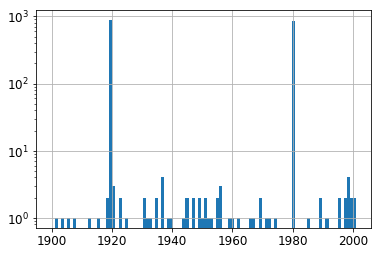

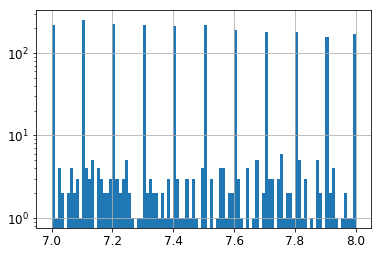

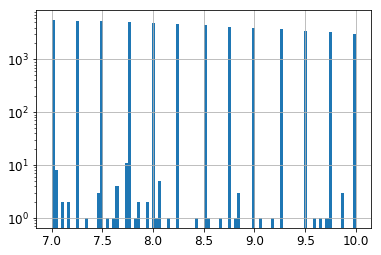

In [6]:
# significant rounding to nearest minute in the taxi data
# Similar but for (4?) seconds in tnp.
taxi.Trip_Seconds.hist(bins = 100,log = True, range = [1900,2001])
plt.show()
# sifnificant rounding to nearest 10th of a mile
taxi.Trip_Miles.hist(bins = 100,log = True, range = [7,8])
plt.show()
# Taxi fare has a strong preference to quarter dollars,
# tnp is similar but bins are larger at 2.5 dollars.
taxi.Final_Fare.hist(bins = 100,log = True, range = [7,10])

### Extra Features

#### Latitude and Longitude to distance and bearing.
This webpage explains how to get distance and bearing from lat/long:
http://www.movable-type.co.uk/scripts/latlong.html

In [7]:
from geopy import distance
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance.great_circle(newport_ri, cleveland_oh).km)

AVG_EARTH_RADIUS = 6371.009  # in km

def haversine_dist(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    km = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return km

def bearing(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def manhattan_dist(lat1, lng1, lat2, lng2):
    x = haversine_dist(lat1,lng1,lat1,lng2)
    y = haversine_dist(lat1,lng1,lat2,lng1)
    return x,y

lat1,lng1 = (41.49008, -71.312796)
lat2,lng2 =  (41.499498, -81.695391)
# almost identical to geopy
haversine_dist(lat1, lng1, lat2, lng2)
manhattan_dist(lat1, lng1, lat2, lng2)


864.2144943393625


(864.2767851133625, 1.0472352985145315)

In [8]:
# Note that about 10% of trips start and end in the same lat/area so these will be zero.
def add_dist_and_bearing(df):
    df["l2_dist_km"] = haversine_dist(df["Pickup_Centroid_Latitude"],
                                       df["Pickup_Centroid_Longitude"],
                                       df["Dropoff_Centroid_Latitude"],
                                       df["Dropoff_Centroid_Longitude"])
    df["x_dist_km"],df["y_dist_km"] = manhattan_dist(df["Pickup_Centroid_Latitude"],
                                       df["Pickup_Centroid_Longitude"],
                                       df["Dropoff_Centroid_Latitude"],
                                       df["Dropoff_Centroid_Longitude"])
    df["bearing"] = bearing(df["Pickup_Centroid_Latitude"],
                               df["Pickup_Centroid_Longitude"],
                               df["Dropoff_Centroid_Latitude"],
                               df["Dropoff_Centroid_Longitude"])



In [9]:
add_dist_and_bearing(taxi)
taxi[taxi.bearing == 0].count()

Trip_Start_Timestamp          15008
Trip_Seconds                  15008
Trip_Miles                    15008
Pickup_Community_Area         15008
Dropoff_Community_Area        15008
Pickup_Centroid_Latitude      15008
Pickup_Centroid_Longitude     15008
Dropoff_Centroid_Latitude     15008
Dropoff_Centroid_Longitude    15008
vel_mph                       15008
Final_Fare                    15008
l2_dist_km                    15008
x_dist_km                     15008
y_dist_km                     15008
bearing                       15008
dtype: int64

#### Airport

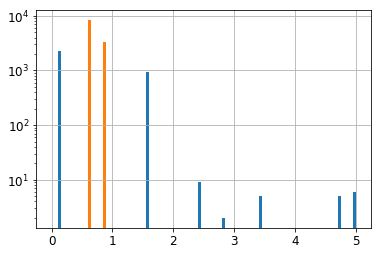

In [10]:
midway = (41.7868, -87.7522)
ohare = (41.9742, -87.9073)

haversine_dist(taxi["Pickup_Centroid_Latitude"],
               taxi["Pickup_Centroid_Longitude"],
              midway[0],
              midway[1]).hist(bins = 100, range = [0,5],log = True)

haversine_dist(taxi["Pickup_Centroid_Latitude"],
               taxi["Pickup_Centroid_Longitude"],
              ohare[0],
              ohare[1]).hist(bins = 100,range = [0,5])

It seems reasonable to include trips within 1km of the airport as airport trips.

In [11]:
def add_airport_col(df,thresh_km = 1):
    midway = (41.7868, -87.7522)
    ohare = (41.9742, -87.9073)
    airport_flag = haversine_dist(df["Pickup_Centroid_Latitude"],
                   df["Pickup_Centroid_Longitude"],
                   midway[0],
                   midway[1]) < thresh_km
    airport_flag |= haversine_dist(df["Pickup_Centroid_Latitude"],
                   df["Pickup_Centroid_Longitude"],
                   ohare[0],
                   ohare[1]) < thresh_km
    print(f"Airport trips pecentage: {airport_flag.mean()*100}")
    df["bAirport"] = airport_flag


In [12]:
add_airport_col(taxi)

Airport trips pecentage: 7.757875716866996


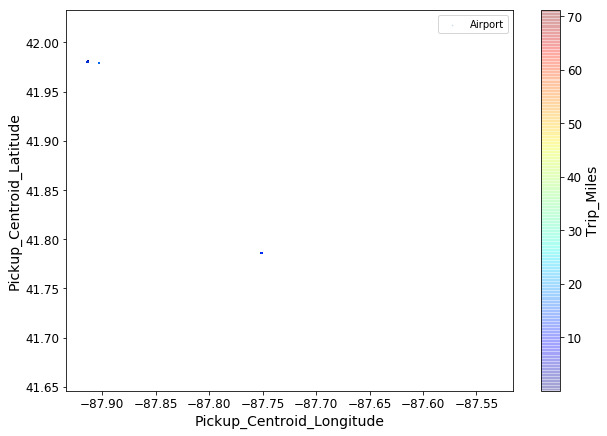

In [13]:
taxi.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = taxi["bAirport"], label = "Airport", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)

#### Datetime

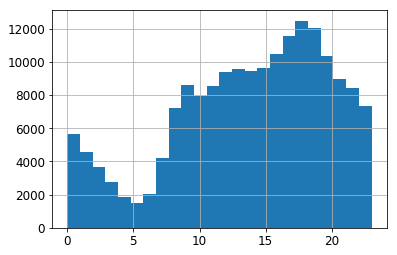

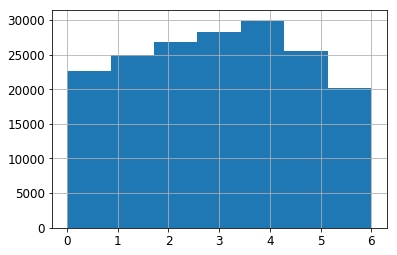

In [14]:
    #Define some new attributes
# use day and hour as categorical
taxi.Trip_Start_Timestamp.dt.hour.hist(bins = 24)
plt.show()
taxi.Trip_Start_Timestamp.dt.dayofweek.hist(bins = 7)

In [6]:
def add_datetime_vars(df):
    df['day_of_wk'] = df.Trip_Start_Timestamp.dt.dayofweek.astype('category')
    df['hour'] = df.Trip_Start_Timestamp.dt.hour.astype('category')
    df.drop('Trip_Start_Timestamp', axis = 1)

#### Feature Investigation for both datasets

In [16]:
def add_all_features(df):
    add_dist_and_bearing(df)
    add_airport_col(df,thresh_km = 1)
    add_datetime_vars(df)

In [17]:
add_all_features(taxi)
add_all_features(tnp)

Airport trips pecentage: 7.757875716866996
Airport trips pecentage: 2.7068868143915483


In [18]:
tnp.groupby("bAirport").Final_Fare.mean()

bAirport
False    11.550226
True     34.005142
Name: Final_Fare, dtype: float32

In [19]:
tnp.groupby("bAirport").Final_Fare.mean()

bAirport
False    11.550226
True     34.005142
Name: Final_Fare, dtype: float32

In [20]:
tnp.groupby("Shared_Trip_Authorized").Final_Fare.mean()

Shared_Trip_Authorized
False    13.322043
True      8.852556
Name: Final_Fare, dtype: float32

In [21]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')

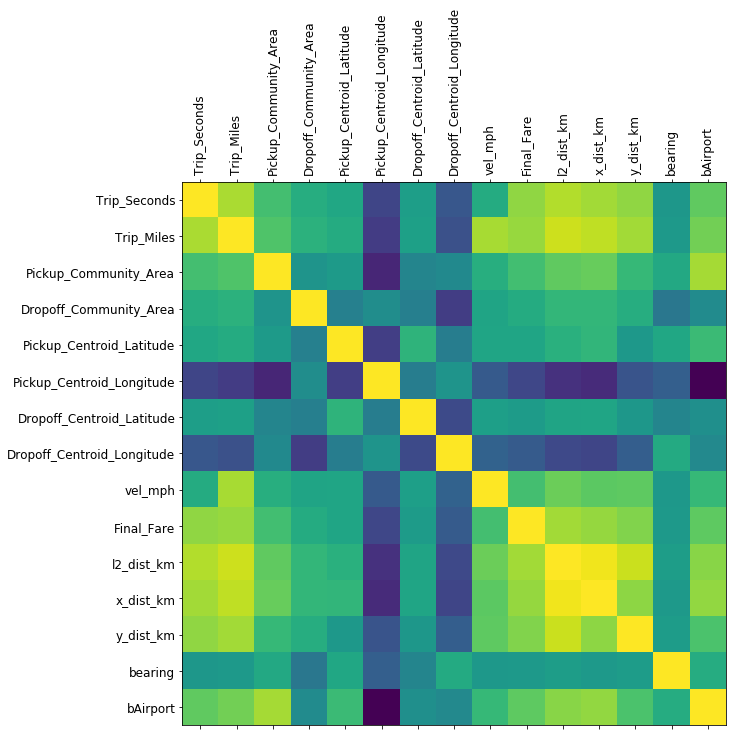

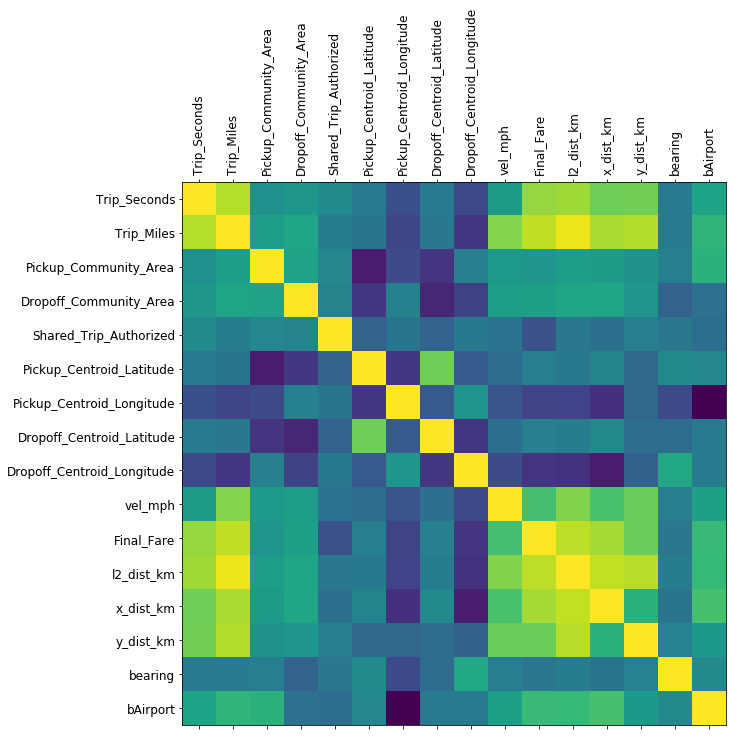

In [22]:
plot_corr(taxi)
plot_corr(tnp)

In [ ]:
corr = taxi.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

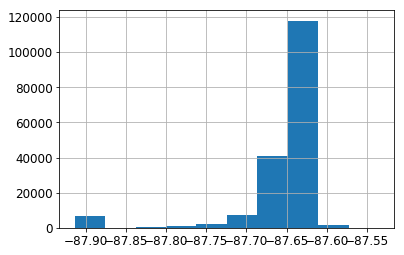

In [24]:
taxi.Dropoff_Centroid_Longitude.hist()

### Save a test/train split on the full dataset

In [1]:
from feature_utils import *
from sklearn.model_selection import train_test_split

%run -i 'inital_preprocessing.py'


Nothing to be done, h5 files exist.


In [2]:
taxi = load_hdf(taxi_out_path,100)
preprocess_trip_data(taxi)
#preprocess_trip_data(tnp, bTaxi = False)
# Python holds on to the extra memory unless you flush...
%reset Out 
add_all_features(taxi)
taxi.info()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)
Airport trips pecentage: 7.765125892964796
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17806833 entries, 28 to 25860154
Data columns (total 17 columns):
Trip_Seconds                  float32
Trip_Miles                    float32
Pickup_Community_Area         float32
Dropoff_Community_Area        float32
Pickup_Centroid_Latitude      float64
Pickup_Centroid_Longitude     float64
Dropoff_Centroid_Latitude     float64
Dropoff_Centroid_Longitude    float64
vel_mph                       float32
Final_Fare                    float32
l2_dist_km                    float64
x_dist_km                     float64
y_dist_km                     float64
bearing                       float64
bAirport                      bool
day_of_wk                     category
hour                          category
dtypes: bool(1), category(2), float32(6), float64(8)
memory usage: 1.6 GB


In [ ]:
taxi_train, taxi_test = train_test_split(taxi, test_size=0.2, random_state=42)
taxi_train.to_hdf(datap/'taxi_train.h5', key='df', mode='w',format='table')
taxi_test.to_hdf(datap/'taxi_test.h5', key='df', mode='w',format='table')

In [2]:
tnp = load_hdf(tnp_out_path,100)
preprocess_trip_data(tnp, bTaxi = False)
# Python holds on to the extra memory unless you flush...
%reset Out 
add_all_features(tnp)
tnp.info()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)
Airport trips pecentage: 2.593165040840958
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15236053 entries, 552 to 17432010
Data columns (total 18 columns):
Trip_Seconds                  float32
Trip_Miles                    float32
Pickup_Community_Area         float32
Dropoff_Community_Area        float32
Shared_Trip_Authorized        bool
Pickup_Centroid_Latitude      float64
Pickup_Centroid_Longitude     float64
Dropoff_Centroid_Latitude     float64
Dropoff_Centroid_Longitude    float64
vel_mph                       float32
Final_Fare                    float32
l2_dist_km                    float64
x_dist_km                     float64
y_dist_km                     float64
bearing                       float64
bAirport                      bool
day_of_wk                     category
hour                          category
dtypes: bool(2), category(2), float32(6), float64(8)
memory us

In [3]:
train, test = train_test_split(tnp, test_size=0.2, random_state=42)
train.to_hdf(datap/'tnp_train.h5', key='df', mode='w',format='table')
test.to_hdf(datap/'tnp_test.h5', key='df', mode='w',format='table')

In [4]:
taxi

,Trip_Start_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,Final_Fare
28,2016-02-01 00:15:00,180.0,0.800000,24.0,24.0,41.901207,-87.676356,41.901207,-87.676356,16.000000,6.500000
29,2016-02-01 00:15:00,1260.0,8.900000,32.0,3.0,41.878866,-87.625192,41.965812,-87.655879,25.428572,26.749998
31,2016-02-01 00:15:00,1260.0,12.900000,56.0,8.0,41.785999,-87.750934,41.898332,-87.620763,36.857143,35.750000
32,2016-02-01 00:15:00,1140.0,15.600000,76.0,24.0,41.979071,-87.903040,41.892493,-87.664746,49.263161,43.000000
33,2016-02-01 00:15:00,1500.0,12.200000,56.0,8.0,41.792592,-87.769615,41.899602,-87.633308,29.280001,36.000000
34,2016-02-01 00:15:00,600.0,2.400000,7.0,8.0,41.929047,-87.651311,41.893216,-87.637844,14.400001,10.500000
35,2016-02-01 00:15:00,1260.0,12.300000,56.0,24.0,41.792592,-87.769615,41.901207,-87.676356,35.142857,36.250000
36,2016-02-01 00:15:00,1020.0,3.300000,6.0,22.0,41.944227,-87.655998,41.922761,-87.699155,11.647058,13.250000
37,2016-02-01 00:15:00,1200.0,17.000000,76.0,28.0,41.980264,-87.913625,41.874005,-87.663518,51.000000,46.250000
39,2016-02-01 00:15:00,360.0,1.100000,8.0,8.0,41.892042,-87.631864,41.907492,-87.635760,11.000000,8.250000


In [ ]:
# Maybie use something like this
class TripPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_fare = 200.0, max_miles = 100.0):
        self.max_fare = max_fare
        self.max_miles = max_miles
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):

In [7]:
preprocess_trip_data(taxi)

KeyError: "['Fare' 'Tip' 'Tolls' 'Extras' 'Trip_Total'] not found in axis"